In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats 

import re

from scipy.stats import chi2_contingency
from scipy.stats import pearsonr, iqr

import geocoder

from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from catboost import CatBoostClassifier, Pool, cv
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, log_loss, f1_score, accuracy_score
from sklearn.feature_selection import SelectKBest, chi2

In [3]:
pd.options.display.float_format = '{:,.4f}'.format

In [4]:
def text_clean(text):
    ''' 
    Функция принимает текст 
    удаляет все цифры, символы, лишние пробелы и приводит в нижний регистр
    возвращает отчищенный текст
    '''
    regex_singular = re.compile(r's\b')
    text = regex_singular.sub('', text.lower())
    
    regex_clean = re.compile(r'[a-z]+')
    list_text = regex_clean.findall(text)

    if len(list_text) > 0:
        return " ".join(list_text)


def count_len_punctuations(text):
    ''' 
    Функция принимает текст 
    считает общее количество символов (без букв, цифр и пробелов) в тексте
    возвращает число
    '''
    regex = re.compile(r'[^\w\s]')
    list_punctuations = regex.findall(text.lower())
    if len(list_punctuations) > 0:
        return len(list_punctuations)
    else:
        return 0

### Осмотр файлов train и test

In [5]:
train_df = pd.read_json('train.json', convert_dates=['created'])
test_df = pd.read_json('test.json', convert_dates=['created'])

In [6]:
# Объединим два датасета train и test для общей обработки данных
all_df = pd.concat([test_df, train_df]).sort_index()

In [7]:
all_df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
0,1.0000,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street,NaN
1,1.0000,2,0,2016-06-24 06:36:34,Prime Soho - between Bleecker and Houston - Ne...,Thompson Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,7210040,-74.0000,d0b5648017832b2427eeb9956d966a14,[https://photos.renthop.com/2/7210040_d824cc71...,2850,176 Thompson Street,NaN
2,1.0000,0,0,2016-06-17 01:23:39,Spacious studio in Prime Location. Cleanbuildi...,Sullivan Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7260,7174566,-74.0026,e6472c7237327dd3903b3d6f6a94515a,[https://photos.renthop.com/2/7174566_ba3a35c5...,2295,115 Sullivan Street,NaN
3,1.0000,2,f9c826104b91d868e69bd25746448c0c,2016-06-21 05:06:02,For immediate access call Bryan.<br /><br />Bo...,Jones Street,"[Hardwood Floors, Dogs Allowed, Cats Allowed]",40.7321,7191391,-74.0028,41735645e0f8f13993c42894023f8e58,[https://photos.renthop.com/2/7191391_8c2f2d49...,2900,23 Jones Street,NaN
4,1.0000,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium


In [8]:
all_df.shape

(124011, 15)

In [9]:
all_df.dtypes

bathrooms                 float64
bedrooms                    int64
building_id                object
created            datetime64[ns]
description                object
display_address            object
features                   object
latitude                  float64
listing_id                  int64
longitude                 float64
manager_id                 object
photos                     object
price                       int64
street_address             object
interest_level             object
dtype: object

In [10]:
#  Преобразуем тип данных колонки 'listing_id' в 'object'
all_df['listing_id'] = all_df['listing_id'].astype('object')

In [11]:
all_df.describe()

,bathrooms,bedrooms,latitude,longitude,price
count,"124,011.0000","124,011.0000","124,011.0000","124,011.0000","124,011.0000"
mean,1.2126,1.5435,40.7376,-73.9494,"3,781.3242"
std,0.5952,1.1102,0.7443,1.3729,"15,829.8756"
min,0.0000,0.0000,0.0000,-121.4880,1.0000
25%,1.0000,1.0000,40.7280,-73.9917,"2,495.0000"
50%,1.0000,1.0000,40.7517,-73.9778,"3,150.0000"
75%,1.0000,2.0000,40.7743,-73.9547,"4,100.0000"
max,112.0000,8.0000,44.8835,0.0000,"4,490,000.0000"


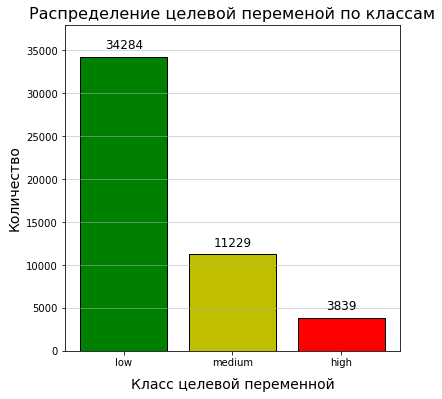

In [12]:
# Посмотрим на распределение целевой переменной по классам
df_target_counts = train_df.interest_level.value_counts()

plt.figure(figsize=(6, 6))
bar = plt.bar(df_target_counts.index,
              df_target_counts, 
              width=0.8, 
              color=['g', 'y', 'r'], 
              edgecolor='k')
plt.title('Распределение целевой переменой по классам', fontsize=16)
plt.xlabel('Класс целевой переменной', labelpad=10, fontsize=14)
plt.ylabel('Количество', labelpad=5, fontsize=14)
plt.ylim(0, 38000)
plt.bar_label(bar, padding=5, fontsize=12)
plt.grid(axis='y', linewidth=0.5)
plt.show()

У целевой переменной есть дисбаланс классов. Необходимо учесть данный момент при обучении модели.

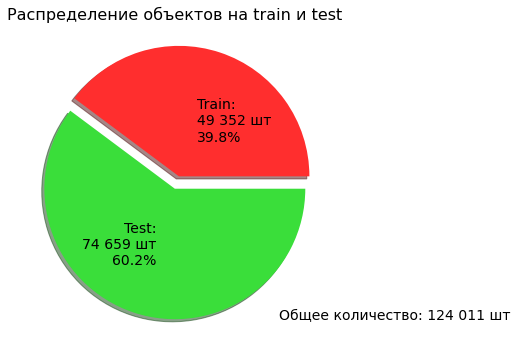

In [13]:
# Посмотрим на распределение объектов на train и test
train_size = train_df.shape[0]
train_size_per = train_df.shape[0]/all_df.shape[0]
test_size = test_df.shape[0]
test_size_per = test_df.shape[0]/all_df.shape[0]
labels = [f'Train:\n{train_size:,d} шт\n{train_size_per:.1%}'.replace(',', ' '),
          f'Test:\n{test_size:,d} шт\n{test_size_per:.1%}'.replace(',', ' ')]
explode = [0.1, 0]
colors = ['#ff2e2e', '#3ade3a']

plt.figure(figsize=(6, 6))
plt.pie(x=[train_size, test_size], 
        labels=labels, 
        colors=colors,
        textprops={'fontsize': 14},
        explode = explode,
        labeldistance=0.45,
        shadow = True)
plt.title('Распределение объектов на train и test', fontsize=16)
plt.text(0.8, -1, 
         f"Общее количество: {train_size + test_size:,d} шт".replace(',', ' '),
         fontsize=14)
plt.show()

Тренировочных данных значительно меньше чем тестовых.

### Анализ пропущенных значений

In [14]:
# Посмотрим на пропущенные значения Nan 
all_df.isna().sum()

bathrooms              0
bedrooms               0
building_id            0
created                0
description            0
display_address        0
features               0
latitude               0
listing_id             0
longitude              0
manager_id             0
photos                 0
price                  0
street_address         0
interest_level     74659
dtype: int64

Пропущенные значения Nan отсутствуют.  
Но из данных видно, что пропущенные записи имеют значение "0", пустую строку "", пустой список [] и т.д.  
В колонках 'bathrooms' и 'bedrooms' значение "0" будем воспринимать как отсутствие соответствующих помещений  
В колонках 'features' и 'photos' лежат пусты списки [].  
В колонках 'latitude' и 'longitude' пропущенные записи имеют значение "0"

In [15]:
# Найдем возможные варианты обозначений для пропущенных значений в колонках типа 'object'
# Примем, что возможные варианты обозначений для пропущенных значений состоят не более чем из 2-х символов
# (Была произведена проверка на большее количество символов)

dict_columns_object = {}

for column in all_df.columns[:-1]:
    set_values_nan_column = set()
    if all_df[column].dtype == 'object':
        for values in all_df[column]:
            if isinstance(values, str) and len(values) <= 2:                
                set_values_nan_column.add(values)
    if len(set_values_nan_column) > 0:
        dict_columns_object[column] = set_values_nan_column

set_values_nan_all = set()
list_columns_object_nan = []

print('Для столбцов:\t\tВарианты пропущенных значений:')
for key, values in dict_columns_object.items():
    print(f'{key}\t\t{values}')
    for value in values:
        set_values_nan_all.add(value)
    list_columns_object_nan.append(key)

Для столбцов:		Варианты пропущенных значений:
building_id		{'0'}
description		{'', '*', '.', ' ', '1', 'a'}
display_address		{'', ' ', '1 '}
street_address		{''}


In [16]:
# Заменим в колонках типа 'object' пропущенные значения на Nan, для удобства обработки данных
all_df[list_columns_object_nan] = all_df[list_columns_object_nan] \
                                      .replace(to_replace = set_values_nan_all, value = np.nan)

In [17]:
# Заменим колонках latitude и longitude значение 0 на Nan, для удобства обработки данных
all_df[['latitude', 'longitude']] = all_df[['latitude', 'longitude']] \
                                    .replace(to_replace = 0, value = np.nan)

### Колонка: 'description'  
Из колонки 'description' создадим 3 признака:
1. Общую длину текста всех особенностей;  
2. Общее количество символов (без букв, цифр и пробелов) в тексте; 
3. Общее количество букв верхнего регистра в тексте. 

In [18]:
# Найдем общую длину текста
all_df['description_len'] = all_df.description.apply(lambda x: len(str(x)))

In [19]:
# Найдем общее количество символов (без букв, цифр и пробелов) в тексте
all_df['description_punct_len'] = all_df.description.apply(lambda x: count_len_punctuations(str(x)))

In [20]:
# Найдем общее количество букв верхнего регистра в тексте
all_df['description_upper_len'] = all_df.description.apply(lambda x: sum(map(str.isupper, str(x))))

### Колонка: 'manager_id'

In [21]:
# Изменим 'manager_id' на более короткий номер, для удобства просмотра таблицы
dict_manager_id = dict(zip(all_df.manager_id.unique(), range(all_df.manager_id.unique().size)))
all_df['manager_id'] = all_df['manager_id'].replace(dict_manager_id).astype('object')

### Колонка: 'created'  
Получим информацию о:  
1. количестве дней нахождения объявления на сайте. Будем считать от максимальной даты;  
2. часе создания объявления; 
3. дне недели создания объявления;  
4. месяце создания объявления.  

In [22]:
all_df[['created']].describe(datetime_is_numeric=True)

,created
count,124011
mean,2016-05-16 04:53:20.169307392
min,2016-04-01 22:12:41
25%,2016-04-23 01:38:07
50%,2016-05-16 05:22:53
75%,2016-06-08 06:15:09.500000
max,2016-06-29 21:55:35


In [23]:
# Найдем количество дней нахождения объявления на сайте
all_df['usage_days'] = all_df[['created']].apply(lambda x: x.max() - x)
all_df.usage_days = all_df.usage_days.dt.days

In [24]:
# Найдем час создания объявления
all_df['hour_created'] = all_df['created'].dt.hour

In [25]:
# Найдем день недели создания объявления
all_df['weekday_created'] = all_df['created'].dt.weekday

In [26]:
# Найдем месяц создания объявления.
all_df['month_created'] = all_df['created'].dt.month

### Колонка: 'interest_level'

In [27]:
# Закодируем целевую переменную
dict_lables = {'high': 0, 'medium': 1, 'low': 2, }
all_df.interest_level = all_df.interest_level.replace(dict_lables)

### Колонки: 'price', 'bathrooms',	'bedrooms'


In [28]:
# Посчитаем количество комнат в квартире (спальная + ванная). Будем считать что в квартире должа быть хоть одна комната.
# То есть если их сумма равна 0, то указываем 1
all_df['sum_rooms'] = all_df.apply(lambda x: x.bathrooms + x.bedrooms if (x.bathrooms + x.bedrooms) > 0 else 1, axis=1)

In [29]:
# Посчитаем цену за одну комнату
all_df['price_for_room'] = all_df.apply(lambda x: x.price / x.sum_rooms, axis=1)

### Колонка: 'photos'
Для 'photos' в основу признака возьмем количество фотографий в объявлении. А пустые списки будем принимать как отсутствие фотографий в объявлении.

In [30]:
# Найдем количество фотографий для каждого объявления из колонки 'photos'
all_df['photos_count'] = all_df.photos.str.len()

### Колонки: 'building_id', 'display_address', 'latitude', 'longitude', 'street_address'
Колонки: 'building_id', 'display_address', 'latitude', 'longitude', 'street_address' отвечают за здание и его местоположение, в котором могут располагаются квартиры. Проанализируем их и попробуем сократить информацию и восстановить пропущенные значения

In [31]:
# Изменим "building_id" на более короткий номер, для удобства просмотра таблицы
dict_building_id = dict(zip(all_df.building_id.unique(), range(all_df.building_id.unique().size)))
del dict_building_id[np.nan] 
all_df['building_id'] = all_df['building_id'].replace(dict_building_id).astype('object')

In [32]:
df_building = all_df[['building_id', 'display_address', 'latitude', 'longitude', 'street_address']]

In [33]:
df_building.isna().sum()

building_id        20664
display_address      363
latitude              39
longitude             39
street_address        23
dtype: int64

In [34]:
for col in df_building:
    print(f'Для столбца {col} уникальных значений: {df_building[col].nunique(): >}')

Для столбца building_id уникальных значений: 11634
Для столбца display_address уникальных значений: 16065
Для столбца latitude уникальных значений: 2674
Для столбца longitude уникальных значений: 1958
Для столбца street_address уникальных значений: 25765


"Пощупав" координаты на googlemaps и сравнивая их с адресами в колонках "display_address" и "street_address", а также посмотрев, что к одному id привязаны одинаковые (либо очень близкие между собой) координаты "latitude" и "longitude", можно сделать предположение что все пять колонок имеют существенную корреляцию между собой, и следовательно все эти колонки можно свести в две координаты широту и долготу, т.е. оставить 'latitude', 'longitude'. Тем более, у этих колонок мало пропущенных  значений.  
При заполнении пропущенных значений в колонках, будем использовать существующий датафрейм и брать в качестве значения моду у уникальных значений по столбцам 'building_id', 'display_address', 'street_address' 

In [35]:
# Посмотри на данные с пропущенными  значениями в 'latitude' и 'longitude'
df_building[df_building.longitude.isna()]

,building_id,display_address,latitude,longitude,street_address
2028,"1,178.0000","Sunset Park, Brooklyn",NaN,NaN,145 28 Street
11348,"3,390.0000",965 Amsterdam,NaN,NaN,965 Amsterdam
23825,"3,390.0000",965 Amsterdam,NaN,NaN,965 Amsterdam
28197,"5,501.0000",e 5th and 1st ave,NaN,NaN,e 5 th
32592,177.0000,330 west 45th,NaN,NaN,330 west 45th
34487,283.0000,W. 156,NaN,NaN,515 W. 156
37426,NaN,88 van Sicklen street,NaN,NaN,Van Sicklen street
39134,"6,390.0000","Flatiron, Kips Bay, Gramercy",NaN,NaN,219 E 28th
43526,474.0000,Rarely Available Stunner!,NaN,NaN,140 West 55th st
46941,233.0000,Madison Ave,NaN,NaN,1632 Madison Ave


Видно, что пропущенные значения в 'latitude' и 'longitude' могут сопровождаться с пропущенными значениями в столбцах 'building_id', 'display_address', 'street_address'. Поэтому придется взаимодействовать со всеми возможными столбцами

In [36]:
# Создадим словарь значений мод для 'latitude' и 'longitude' по ключу из уникальных значений столбца "building_id".
# Будем брать только те "building_id", в которых есть пропущенные значения в 'latitude' и 'longitude'
list_building_for_nan_gps = df_building[(df_building.latitude.isna()) & (-df_building.building_id.isna())] \
                            .building_id.unique()
dict_building_for_nan_gps = df_building[df_building.building_id.isin(list_building_for_nan_gps)] \
                            .groupby('building_id')[['latitude', 'longitude']] \
                            .agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else np.nan) \
                            .query('(latitude > 0) & (longitude < 0)').to_dict()

In [37]:
# Создадим словарь значений мод для 'latitude' и 'longitude' по ключу из уникальных значений столбца "display_address".
# Будем брать только те "display_address", в которых есть пропущенные значения в 'latitude' и 'longitude'
list_display_address_for_gps = df_building[(df_building.latitude.isna()) & (-df_building.display_address.isna())] \
                               .display_address.unique()
dict_display_address_for_gps = df_building[df_building.display_address.isin(list_display_address_for_gps)] \
                               .groupby('display_address')[['latitude', 'longitude']] \
                               .agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else np.nan) \
                               .query('(latitude > 0) & (longitude < 0)').to_dict()

In [38]:
# Создадим словарь значений мод для 'latitude' и 'longitude' по ключу из уникальных значений столбца "street_address".
# Будем брать только те "street_address", в которых есть пропущенные значения в 'latitude' и 'longitude'
list_street_address_for_gps = df_building[(df_building.latitude.isna()) & (-df_building.street_address.isna())] \
                              .street_address.unique()
dict_street_address_for_gps = df_building[df_building.street_address.isin(list_street_address_for_gps)] \
                              .groupby('street_address')[['latitude', 'longitude']] \
                              .agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else np.nan) \
                              .query('(latitude > 0) & (longitude < 0)').to_dict()

In [39]:
# Восстановим пропущенные значения для 'latitude' и 'longitude' по получившимся словарям
for row_index, _ in df_building[df_building.latitude.isna()].iterrows():
    building_id = df_building.loc[row_index,'building_id']
    display_address = df_building.loc[row_index,'display_address']
    street_address = df_building.loc[row_index,'street_address']
    for col_gps in ['latitude', 'longitude']:
        if building_id in dict_building_for_nan_gps[col_gps].keys():
            df_building.loc[row_index,col_gps] = dict_building_for_nan_gps[col_gps][building_id]
        elif display_address in dict_display_address_for_gps[col_gps].keys():
            df_building.loc[row_index,col_gps] = dict_display_address_for_gps[col_gps][display_address]
        elif street_address in dict_street_address_for_gps[col_gps].keys():
            df_building.loc[row_index,col_gps] = dict_street_address_for_gps[col_gps][street_address] 

C:\Users\Maksim\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [40]:
# Повторно посмотри на данные с пропущенными значениями в 'latitude' и 'longitude' после первой обработки
df_building[df_building.longitude.isna()]

,building_id,display_address,latitude,longitude,street_address
28197,"5,501.0000",e 5th and 1st ave,NaN,NaN,e 5 th
37426,NaN,88 van Sicklen street,NaN,NaN,Van Sicklen street
39134,"6,390.0000","Flatiron, Kips Bay, Gramercy",NaN,NaN,219 E 28th
51400,"7,490.0000",61 west 10th street,NaN,NaN,61 west 10th street
58574,"8,027.0000",844 St. Johns Place,NaN,NaN,844 St. Johns Place
60891,"8,195.0000",29 st,NaN,NaN,300 e 29 st
65830,"8,494.0000",23 West 109th street,NaN,NaN,23 West 109th street
92660,"10,152.0000",west 71,NaN,NaN,267 west 71


Удалось восстановить не все значения. Проблема в том, что в столбцах "display_address" и "street_address" адрес указан в разных вариантах, то есть один и тот же адрес может выглядеть по-разному, в т.ч. с сокращениями. Можно попробовать поискать похожие варианты адреса по тексту и взять их, но мы попробуем восстановить координаты по колонке "street_address" при помощи библиотеки geocoder.arcgis

In [41]:
# Создадим список необходимых адресов для поиска их координат
# Так как подробные адреса есть в разных колонках, то лучше взять из обоих (по максимальной длине текста)
series_address_for_gps_2 = df_building[df_building.longitude.isna()] \
                           .apply(lambda x: x.display_address 
                                 if len(x.display_address) > len(x.street_address) 
                                 else x.street_address, axis=1)

In [42]:
dict_row_index_for_gps_2 = dict()
latitude = dict()
longitude = dict()
for row_index, address in series_address_for_gps_2.items():
    address = address + ', New York, USA'
    location = geocoder.arcgis(address, timeout=10).json
    if location != None:
        latitude[row_index] = location['lat']
        longitude[row_index] = location['lng']
    else:
        latitude[row_index] = np.nan
        longitude[row_index] = np.nan
dict_row_index_for_gps_2['latitude'] = latitude
dict_row_index_for_gps_2['longitude'] = longitude

In [43]:
dict_row_index_for_gps_2

{'latitude': {28197: 40.725800041447314,
  37426: 40.60222052997082,
  39134: 40.739550000000065,
  51400: 40.734695000916105,
  58574: 40.67152461999632,
  60891: 40.74108691454916,
  65830: 40.80039716541687,
  92660: 40.77896863258397},
 'longitude': {28197: -73.98661995026592,
  37426: -73.97442000637503,
  39134: -73.97707999999994,
  51400: -73.99820709321564,
  58574: -73.95015657597695,
  60891: -73.9776790579677,
  65830: -73.95945187930906,
  92660: -73.9842798905374}}

In [44]:
# Восстановим пропущенные оставшиеся значения для 'latitude' и 'longitude' по получившимся словарю 'dict_row_index_for_gps_2'
for row_index, _ in df_building[df_building.latitude.isna()].iterrows():
    for col_gps in ['latitude', 'longitude']:
            df_building.loc[row_index,col_gps] = dict_row_index_for_gps_2[col_gps][row_index]

C:\Users\Maksim\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [45]:
# Еще раз посмотри на данные с пропущенными  значениями в 'latitude' и 'longitude' после второй обработки
df_building[['latitude', 'longitude']].isna().sum()

latitude     0
longitude    0
dtype: int64

In [46]:
# Заменим полученные колонки 'latitude' и 'longitude' в основной таблице "all_df"
all_df[['latitude', 'longitude']] = df_building[['latitude', 'longitude']]

### Колонка: 'features'
Из колонки 'features' выделим:  
1. Уникальные значения особенностей квартиры и сделаем унитарное кодирование (One Hot Encoding) для всех объявлений. Соответственно в строках c отсутствием особенностей будут везде 0 (то есть в объявлении не указана данная особенность);  
2. Количество указанных особенностей;
3. Общую длину текста всех особенностей;  
4. Общее количество символов (без букв, цифр и пробелов) в тексте; 
5. Общее количество букв верхнего регистра в тексте. 

пункты №2-5 могут влиять на содержательность и эмоциональность текста в особенностях квартиры.

In [47]:
# 1. Сделаем унитарное кодирование (One Hot Encoding) для всех объявлений

# Посмотри на варианты особенностей квартиры
# Создадим таблицу уникальных значений особенностей с частотой их упоминания
dict_unique_features = dict()

for list_features in all_df.features:
    if len(list_features) > 0:
        for feature in list_features:
            feature = text_clean(feature)
            if feature is not None:
                if feature not in dict_unique_features.keys():
                    dict_unique_features[feature] = 1
                else:
                    dict_unique_features[feature] += 1
    
# Если уникальная особенность встречается всего один раз, то это не дает никакой пользы для алгоритма обучения
# Удалим признаки c его количеством упоминания равного "1"                
dict_unique_features = {key:value for key, value in dict_unique_features.items() if value > 1}                
                
df_features_count = pd.DataFrame.from_dict(dict_unique_features, 
                                           orient='index', 
                                           columns=['features_count']).sort_values('features_count', ascending=False)

print(f'Количество  уникальных особенностей квартиры: {len(dict_unique_features.keys())} шт.')
print(f'\nВарианты особенностей квартиры: {dict_unique_features.keys()}')

Количество  уникальных особенностей квартиры: 778 шт.

Варианты особенностей квартиры: dict_keys(['elevator', 'laundry in building', 'laundry in unit', 'dishwasher', 'hardwood floor', 'outdoor space', 'pre war', 'dog allowed', 'cat allowed', 'dining room', 'roof deck', 'doorman', 'fitnes center', 'high speed internet', 'wheelchair acces', 'no fee', 'swimming pool', 'loft', 'fireplace', 'exclusive', 'hardwood', 'high ceiling', 'marble bath', 'granite kitchen', 'light', 'eat in kitchen', 'balcony', 'terrace', 'furnished', 'newly renovated', 'reduced fee', 'pet on approval', 'common outdoor space', 'parking space', 'concierge', 'playroom', 'washer in unit', 'dryer in unit', 'pool', 'garage', 'stainles steel appliance', 'large window', 'all pet ok', 'renovated', 'private balcony', 'private outdoor space', 'publicoutdoor', 'new construction', 'laundry room', 'garden patio', 'multi level', 'highrise', 'laundry', 'simplex', 'actual apt photo', 'subway', 'live in superintendent', 'on site laun

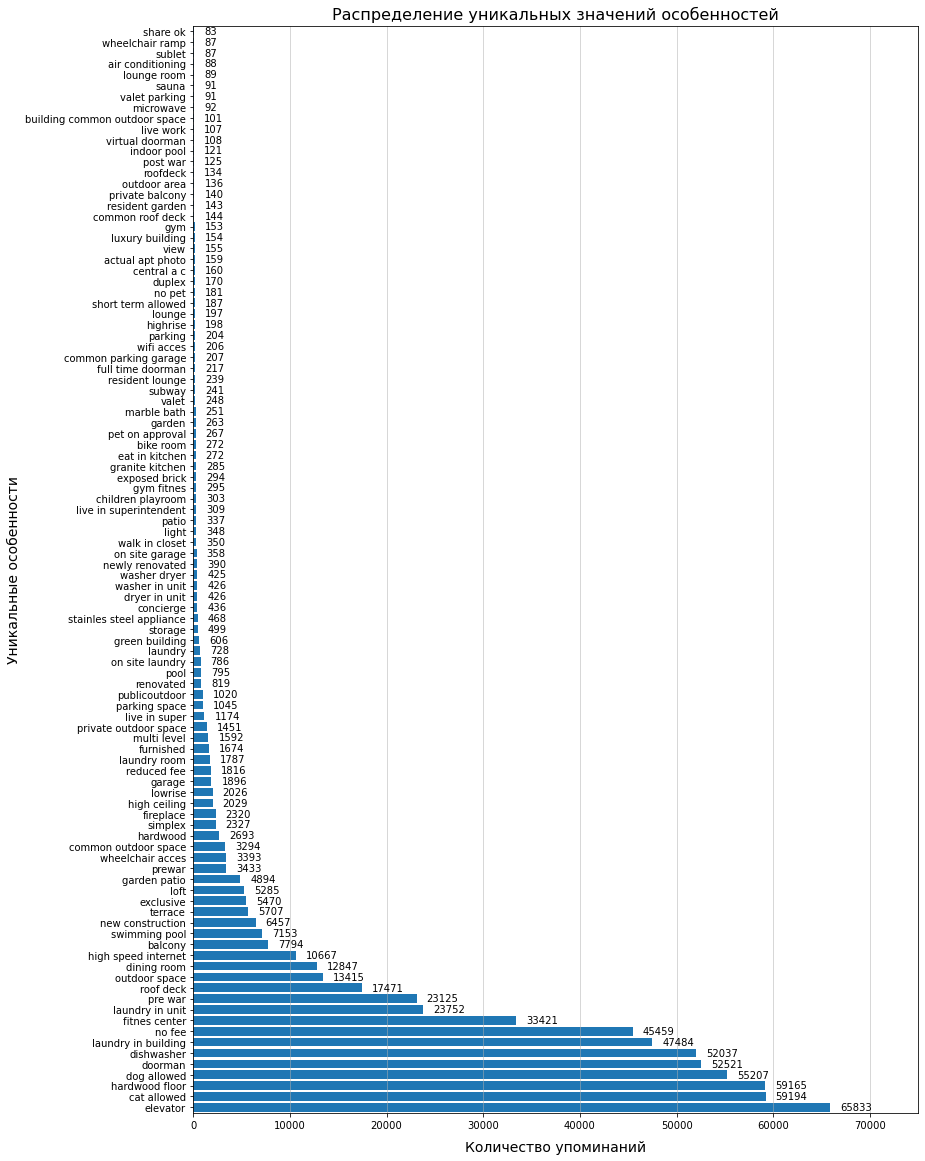

In [48]:
# Посмотрим на распределение уникальных значений особенностей c частотой их упоминания (выведим первые 100 значений)
fig = plt.figure(figsize=(13, 20))

barh = plt.barh(df_features_count[:100].index,
                df_features_count[:100].features_count)
plt.title('Распределение уникальных значений особенностей', fontsize=16)
plt.xlabel('Количество упоминаний', labelpad=10, fontsize=14)
plt.ylabel('Уникальные особенности', fontsize=14)
plt.xlim(0, 75000)
plt.bar_label(barh, padding=10, fontsize=10)
plt.grid(axis='x', linewidth=0.5)
plt.margins(0.001)
plt.show()

In [49]:
# Создадим пустую таблицу для каждого объявления для кодирования особенностями (0, 1)
df_features = pd.DataFrame(
                            np.zeros((all_df.shape[0], df_features_count.shape[0])),
                            columns=df_features_count.index,
                            index = all_df.index,
                            dtype='int'
                           )
df_features['interest_level'] = all_df['interest_level']

In [50]:
%%time
# Заполним таблицу для каждого объявления с совпадающими у него особенностями значениями 1
for index, features in all_df[all_df.features.str.len() > 0].features.items():
    for feature in features:
        feature = text_clean(feature)
        if feature in dict_unique_features.keys():
            df_features.loc[index, feature] = 1

Wall time: 33min 17s


In [51]:
# Если уникальная особенность встречается только в train или test датасете,
# то это так же не дает никакой пользы для алгоритма обучения.
# Удалим такие особенности.
set_drop_df_features = set(df_features.loc[df_features.interest_level.notna(), 
                                        df_features[df_features.interest_level.notna()
                                        ].sum() == 0].columns.tolist() +
                           df_features.loc[df_features.interest_level.isna(), 
                                        df_features[df_features.interest_level.isna()
                                        ].sum() == 0].iloc[:,:-1].columns.tolist())
df_features = df_features.drop(set_drop_df_features, axis = 1)

In [52]:
df_features.head()

,elevator,cat allowed,hardwood floor,dog allowed,doorman,dishwasher,laundry in building,no fee,fitnes center,laundry in unit,...,loft area,combo washer dryer,garden roof deck,stainles kitchen,large living area,th nd,spotles laundry,large apartment,great view of the neighborhood,interest_level
0,1,0,1,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN
1,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
3,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
4,0,1,1,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0000


Получилось довольно много признаков (колонок).  
Для отбора уникальных признаков в датасете 'df_features' будем использовать разные методы, которые помогут определить наиболее значимые признаки для целевой переменной:  
1. При помощи корреляции признаков к целевой переменной (удалить слабо коррелирующие признаки к целевой переменной);
2. При помощи корреляции признаков между собой (удалить сильно коррелирующие признаки);
3. При помощи статистического метода Хи-квадрат (удалить признаки не имеющие зависимость от целевой переменной);  
4. При помощи алгоритма RandomForestClassifier (удалить наименее значимые признаки для модели);
5. При помощи алгоритма CatBoostClassifier (удалить наименее значимые признаки для модели).  

Создадим 5 списков для удаления признаков и объединим в один. В итоге оставим до 100 признаков.  
  
Для контроля качества датасета 'df_features', при удалении признаков, будем проверять оставшийся датасет при помощи группы базовых моделей ML (RandomForest, CatBoost, LogisticRegression, LGBMC, XGBC) по показателям log-loss и f1-score, сравнивания с первоначальными показателями.

In [53]:
# Для дальнейшего отбора признаков, оставим строки только с целевой переменной (для train)
train_df_features = df_features[df_features.interest_level.notna()]

X = train_df_features.drop('interest_level', axis=1)
y = train_df_features.interest_level

In [54]:
# Зададим базовые модели обучения ML
dict_models = {RandomForestClassifier: {'n_estimators':500, 
                                        'n_jobs':-1, 
                                        'random_state':42},
                   CatBoostClassifier: {'iterations':500, 
                                        'verbose':False,
                                        'loss_function':'MultiClass', 
                                        'random_state':42},
                   LogisticRegression: {'max_iter':200, 
                                        'n_jobs':-1, 
                                        'random_state':42},               
                   lgb.LGBMClassifier: {'n_estimators':500, 
                                        'n_jobs':-1, 
                                        'random_state':42},
                    xgb.XGBClassifier: {'n_estimators':100,
                                        'use_label_encoder':False,
                                        'eval_metric':'mlogloss',
                                        'n_jobs':-1, 
                                        'random_state':42}}

In [55]:
def model_evaluation(X, y, dict_models):
    '''
    Функция принимает словарь с базовыми моделями обучения ML, матрицу признаков и вектор целевой переменной.
    Возвращает таблицу DF с показателями log-loss и f1-score по каждой модели обучения.
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    df_model_evaluation = pd.DataFrame(columns=['model_name', 'logloss', 'f1_score']).set_index('model_name')
    
    for estimator, params in dict_models.items():
        model = estimator(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)
        
        loglos = log_loss(y_test, y_pred_prob)
        f_1_score = f1_score(y_test, y_pred, average='macro')
        model_name = str(estimator.__name__)
        
        df_model_evaluation.loc[model_name] = [loglos, f_1_score]
    
    return df_model_evaluation

In [56]:
# Зафиксируем начальные показатели моделей для всех колонок (особенностей) датасета 'df_features'
df_model_basic = model_evaluation(X, y, dict_models)
df_model_basic

,logloss,f1_score
model_name,,
RandomForestClassifier,0.9944,0.3886
CatBoostClassifier,0.7211,0.3196
LogisticRegression,0.7408,0.3137
LGBMClassifier,0.7331,0.3512
XGBClassifier,0.7229,0.3272


In [57]:
# 1.1 Отбор признаков для их удаления, при помощи определения слабой корреляции признаков к целевой переменной
df_features_not_corr_with_target = pd.DataFrame(columns=['features', 'coef_pearsonr']).set_index('features')
target_name = 'interest_level'

for feature in train_df_features:
    if target_name != feature:
        coef_pearsonr = pearsonr(train_df_features[feature], train_df_features[target_name])[0]
        df_features_not_corr_with_target.loc[feature] = coef_pearsonr
df_features_not_corr_with_target.sort_values('coef_pearsonr', ascending=False, inplace=True)

list_drop_features_not_corr_with_target = df_features_not_corr_with_target[
                                            abs(df_features_not_corr_with_target.coef_pearsonr) < 0.002
                                            ].index.tolist()

print(f'Удалено {len(list_drop_features_not_corr_with_target)} признаков при помощи корреляции признаков к целевой переменной')

df_model_features_corr_with_target = model_evaluation(X.drop(list_drop_features_not_corr_with_target, axis=1),
                                                      y, dict_models)

df_model_features_corr_with_target['logloss_more_basic'] = df_model_features_corr_with_target['logloss'] \
                                                             - df_model_basic['logloss']
df_model_features_corr_with_target['f1_score_more_basic'] = df_model_features_corr_with_target['f1_score'] \
                                                              - df_model_basic['f1_score']
df_model_features_corr_with_target

Удалено 65 признаков при помощи корреляции признаков к целевой переменной


,logloss,f1_score,logloss_more_basic,f1_score_more_basic
model_name,,,,
RandomForestClassifier,1.0040,0.3884,0.0096,-0.0002
CatBoostClassifier,0.7209,0.3190,-0.0002,-0.0005
LogisticRegression,0.7406,0.3130,-0.0002,-0.0007
LGBMClassifier,0.7318,0.3542,-0.0013,0.0030
XGBClassifier,0.7230,0.3285,0.0000,0.0013


In [58]:
# 1.2 Отбор признаков для их удаления, при помощи определения сильной корреляции признаков между собой
correlation_matrix = train_df_features.corr()

df_corr_features = pd.DataFrame(columns=['features', 'features_2', 'coef_corr']).set_index('features')

for index_col in range(len(correlation_matrix.columns)): 
    for index_row in range(index_col):
        coef_corr = correlation_matrix.iloc[index_row, index_col]
        if abs(coef_corr) > 0.85:
            col_name = correlation_matrix.columns[index_col]
            row_name = correlation_matrix.index[index_row]
            df_corr_features.loc[row_name] = [col_name, coef_corr]
df_corr_features.sort_values('coef_corr', ascending=False, inplace=True)

list_drop_corr_features = df_corr_features.index.tolist()

print(f'Удалено {len(list_drop_corr_features)} признаков при помощи корреляции признаков между собой')

df_model_not_corr_features = model_evaluation(X.drop(list_drop_corr_features, axis=1),
                                              y, 
                                              dict_models)

df_model_not_corr_features['logloss_more_basic'] = df_model_not_corr_features['logloss'] \
                                                     - df_model_basic['logloss']
df_model_not_corr_features['f1_score_more_basic'] = df_model_not_corr_features['f1_score'] \
                                                      - df_model_basic['f1_score']
df_model_not_corr_features

Удалено 142 признаков при помощи корреляции признаков между собой


,logloss,f1_score,logloss_more_basic,f1_score_more_basic
model_name,,,,
RandomForestClassifier,0.9770,0.3915,-0.0174,0.0029
CatBoostClassifier,0.7210,0.3215,-0.0001,0.0019
LogisticRegression,0.7410,0.3123,0.0002,-0.0014
LGBMClassifier,0.7324,0.3479,-0.0006,-0.0033
XGBClassifier,0.7231,0.3237,0.0002,-0.0035


In [59]:
# 1.3 Отбор признаков для их удаления, при помощи статистического метода Хи-квадрат.
list_drop_feature_chi2 = []

for col in train_df_features.iloc[:,:-1]:
    crosstable = pd.crosstab(train_df_features.interest_level, train_df_features[col], margins=True)
    chi2_value, p, dof, expctd = chi2_contingency(crosstable.iloc[0:3,0:2], correction=True)
    if p > 0.1:
        list_drop_feature_chi2.append(col)

print(f'Удалено {len(list_drop_feature_chi2)} признаков при помощи статистического метода Хи-квадрат')

df_model_feature_chi2 = model_evaluation(X.drop(list_drop_feature_chi2, axis=1),
                                         y, 
                                         dict_models)

df_model_feature_chi2['logloss_more_basic'] = df_model_feature_chi2['logloss'] \
                                                - df_model_basic['logloss']
df_model_feature_chi2['f1_score_more_basic'] = df_model_feature_chi2['f1_score'] \
                                                 - df_model_basic['f1_score']
df_model_feature_chi2

Удалено 366 признаков при помощи статистического метода Хи-квадрат


,logloss,f1_score,logloss_more_basic,f1_score_more_basic
model_name,,,,
RandomForestClassifier,1.0008,0.3881,0.0064,-0.0005
CatBoostClassifier,0.7195,0.3242,-0.0016,0.0047
LogisticRegression,0.7398,0.3139,-0.0009,0.0002
LGBMClassifier,0.7334,0.3485,0.0003,-0.0028
XGBClassifier,0.7223,0.3287,-0.0006,0.0015


In [60]:
# Для отбора признаков при помощи алгоритмов RandomForest и CatBoostClassifier,
# удалим из колонок (особенностей) датасета 'df_features' колонки, найденные при помощи корреляции (п.1.1 и п.1.2)
X_for_model = X.drop(np.unique(list_drop_features_not_corr_with_target + list_drop_corr_features), axis=1)

In [61]:
# 1.4. Отбор признаков для их удаления, при помощи алгоритма RandomForest.
model_1 = RandomForestClassifier(n_estimators=500, 
                                 n_jobs=-1, 
                                 random_state=42)
model_1.fit(X_for_model, y)

feature_rf = pd.DataFrame(model_1.feature_importances_, index=X_for_model.columns).sort_values(0, ascending=False)
df_feature_not_importances_rf = feature_rf[feature_rf.iloc[:,0] <= 0.0005]
list_drop_feature_not_importances_rf = df_feature_not_importances_rf.index.tolist()

print(f'Удалено {len(list_drop_feature_not_importances_rf)} признаков при помощи RandomForestClassifier')

df_model_feature_importances_rf = model_evaluation(X_for_model.drop(list_drop_feature_not_importances_rf, axis=1),
                                                   y, 
                                                   dict_models)

df_model_feature_importances_rf['logloss_more_basic'] = df_model_feature_importances_rf['logloss'] \
                                                          - df_model_basic['logloss']
df_model_feature_importances_rf['f1_score_more_basic'] = df_model_feature_importances_rf['f1_score'] \
                                                           - df_model_basic['f1_score']
df_model_feature_importances_rf

Удалено 314 признаков при помощи RandomForestClassifier


,logloss,f1_score,logloss_more_basic,f1_score_more_basic
model_name,,,,
RandomForestClassifier,0.9960,0.3919,0.0016,0.0033
CatBoostClassifier,0.7202,0.3405,-0.0009,0.0209
LogisticRegression,0.7408,0.3128,-0.0000,-0.0009
LGBMClassifier,0.7320,0.3564,-0.0010,0.0051
XGBClassifier,0.7232,0.3349,0.0003,0.0077


<AxesSubplot:>

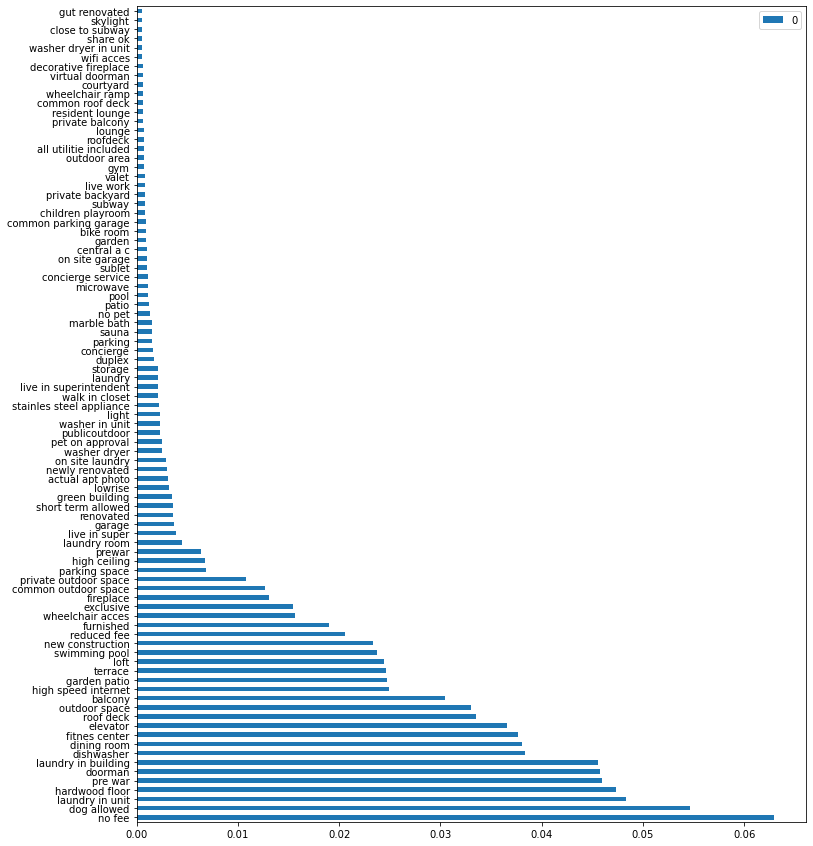

In [62]:
# Посмотрим на оставшиеся (значимые) признаки для алгоритма RandomForest.
feature_rf[feature_rf.iloc[:,0] > 0.0005].plot.barh(figsize=(12,15))

In [63]:
# 1.5. Отбор признаков для их удаления, при помощи алгоритма CatBoost.
model_2 = CatBoostClassifier(loss_function='MultiClass',
                             iterations=500,
                             verbose=False,
                             random_state=42)
model_2.fit(X_for_model, y, verbose=False)

feature_cb = model_2.get_feature_importance(prettified=True)
df_feature_not_importances_cb = feature_cb[feature_cb.Importances <= 0.01]
list_drop_feature_not_importances_cb = df_feature_not_importances_cb['Feature Id'].values.tolist()

print(f'Удалено {len(list_drop_feature_not_importances_cb)} признаков при помощи CatBoostClassifier')

df_model_feature_importances_cb = model_evaluation(X_for_model.drop(list_drop_feature_not_importances_cb, axis=1),
                                                   y, 
                                                   dict_models)

df_model_feature_importances_cb['logloss_more_basic'] = df_model_feature_importances_cb['logloss'] \
                                                          - df_model_basic['logloss']
df_model_feature_importances_cb['f1_score_more_basic'] = df_model_feature_importances_cb['f1_score'] \
                                                           - df_model_basic['f1_score']
df_model_feature_importances_cb

Удалено 305 признаков при помощи CatBoostClassifier


,logloss,f1_score,logloss_more_basic,f1_score_more_basic
model_name,,,,
RandomForestClassifier,0.9936,0.3915,-0.0008,0.0029
CatBoostClassifier,0.7210,0.3349,-0.0001,0.0153
LogisticRegression,0.7408,0.3125,0.0001,-0.0012
LGBMClassifier,0.7330,0.3499,-0.0001,-0.0013
XGBClassifier,0.7213,0.3336,-0.0016,0.0064


<AxesSubplot:ylabel='Feature Id'>

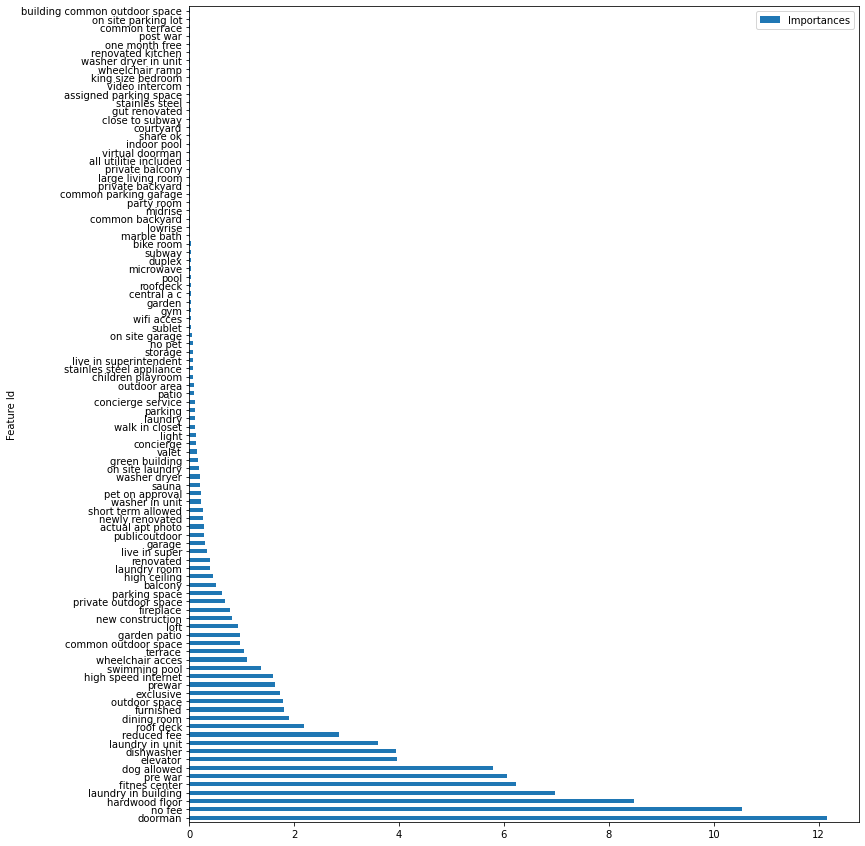

In [64]:
# Посмотрим на оставшиеся (значимые) признаки для алгоритма CatBoost.
feature_cb[feature_cb.Importances > 0.01].plot.barh('Feature Id', figsize=(12,15))

In [65]:
# Соберем все признаки из пяти методов в один список
list_drop_feature = np.unique(list_drop_features_not_corr_with_target + 
                              list_drop_corr_features +
                              list_drop_feature_chi2 + 
                              list_drop_feature_not_importances_rf +
                              list_drop_feature_not_importances_cb)
print(f'Итого удалено {len(list_drop_feature)} признаков при помощи пяти методов')

Итого удалено 532 признаков при помощи пяти методов


In [66]:
# Проверим окончательные показатели моделей для оставшихся колонок (особенностей) датасета 'df_features'
df_model_drop_featur = model_evaluation(X.drop(list_drop_feature, axis=1),
                                        y, 
                                        dict_models)
df_model_drop_featur['logloss_more_basic'] = df_model_drop_featur['logloss'] - df_model_basic['logloss']
df_model_drop_featur['f1_score_more_basic'] = df_model_drop_featur['f1_score'] - df_model_basic['f1_score']
df_model_drop_featur

,logloss,f1_score,logloss_more_basic,f1_score_more_basic
model_name,,,,
RandomForestClassifier,0.9861,0.3923,-0.0083,0.0036
CatBoostClassifier,0.7207,0.3411,-0.0005,0.0216
LogisticRegression,0.7405,0.3129,-0.0002,-0.0008
LGBMClassifier,0.7324,0.3518,-0.0006,0.0006
XGBClassifier,0.7229,0.3388,-0.0000,0.0116


Как видно, показатели log-loss и f1-score по каждой модели обучения практически не изменились (стали даже чуть лучше) при удалении 532 признака особенностей. Оставшиеся 74 особенности добавим в общий датасет "all_df"

In [67]:
# Добавим новые признаки в общий датасет "all_df"
df_features = df_features.drop(list_drop_feature, axis=1).iloc[:,:-1]
all_df = all_df.merge(df_features, left_index=True, right_index=True)

In [68]:
# 2.Найдем количество указанных особенностей
all_df['features_count'] = all_df.features.str.len()

In [69]:
# 3.Найдем общую длину текста всех особенностей
all_df['features_len'] = all_df.features.apply(lambda x: len(' '.join(x)))

In [70]:
# 4.Найдем общее количество символов (без букв, цифр и пробелов) в тексте
all_df['features_punct_len'] = all_df.features.apply(lambda x: count_len_punctuations(' '.join(x)))

In [71]:
# 5.Найдем общее количество букв верхнего регистра в тексте
all_df['features_upper_len'] = all_df.features.apply(lambda x: sum(map(str.isupper, ' '.join(x))))

### Удаление лишних колонок и сохранение итогового dataframe "all_df" в файл

In [72]:
# Удалим лишние колонки
all_df = all_df.drop(['created', 'listing_id', 'building_id', 'description', 
                      'display_address', 'features', 'photos', 'street_address'], axis=1)

In [73]:
# Сохраним получившийся dataframe "all_df" в файл
all_df.to_csv('all_df.csv', index=False)

# Анализ и визуализация данных

In [74]:
# Загрузим получившийся dataframe "all_df" из файла
all_df = pd.read_csv('all_df.csv', dtype = {'manager_id': str})

In [75]:
all_df.head()

,bathrooms,bedrooms,latitude,longitude,manager_id,price,interest_level,description_len,description_punct_len,description_upper_len,...,share ok,washer dryer in unit,concierge service,all utilitie included,gut renovated,close to subway,features_count,features_len,features_punct_len,features_upper_len
0,1.0000,1,40.7185,-73.9865,0,2950,NaN,587,48,37,...,0,0,0,0,0,0,6,85,0,10
1,1.0000,2,40.7278,-74.0000,1,2850,NaN,245,16,15,...,0,0,0,0,0,0,3,33,1,6
2,1.0000,0,40.7260,-74.0026,2,2295,NaN,268,7,9,...,0,0,0,0,0,0,3,33,1,6
3,1.0000,2,40.7321,-74.0028,3,2900,NaN,146,11,5,...,0,0,0,0,0,0,3,41,0,6
4,1.0000,1,40.7108,-73.9539,4,2400,1.0000,553,80,45,...,0,0,0,0,0,0,7,92,1,13


In [76]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124011 entries, 0 to 124010
Data columns (total 95 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   bathrooms                 124011 non-null  float64
 1   bedrooms                  124011 non-null  int64  
 2   latitude                  124011 non-null  float64
 3   longitude                 124011 non-null  float64
 4   manager_id                124011 non-null  object 
 5   price                     124011 non-null  int64  
 6   interest_level            49352 non-null   float64
 7   description_len           124011 non-null  int64  
 8   description_punct_len     124011 non-null  int64  
 9   description_upper_len     124011 non-null  int64  
 10  usage_days                124011 non-null  int64  
 11  hour_created              124011 non-null  int64  
 12  weekday_created           124011 non-null  int64  
 13  month_created             124011 non-null  i

In [77]:
# Разделим датасет "all_df" на train и test.
train_df = all_df[all_df.interest_level.notna()]
test_df = all_df[all_df.interest_level.isna()].drop('interest_level', axis=1)

print(f'Размер train_df:\n\tобъектов = {train_df.shape[0]} шт.\n\tпризнаков = {train_df.shape[1]} шт.')
print(f'Размер test_df:\n\tобъектов = {test_df.shape[0]} шт.\n\tпризнаков = {test_df.shape[1]} шт.')

Размер train_df:
	объектов = 49352 шт.
	признаков = 95 шт.
Размер test_df:
	объектов = 74659 шт.
	признаков = 94 шт.


In [78]:
def calculate_outlier_cutoff(array, coef_cutoff, cut_array=False):
    '''
    Функция принимает одномерный массив и коэффициент при межквартильном размахе.
    Возвращает:
     - нижнию и верхнию отсечку для определения выбросов в данных;
     - одномерный массив без выбросов, при cut_array=True.
    '''
    array = pd.Series(array)
    q_25 = array.quantile(q=0.25)
    q_75 = array.quantile(q=0.75)
    iqr = q_75 - q_25
    lower = q_25 - iqr * coef_cutoff
    upper = q_75 + iqr * coef_cutoff    
    if cut_array == True:        
        cut_array = array[array.between(lower, upper)]
        return cut_array
    else:
        return lower, upper

Посмотрим на распределение классов объектов по географическим координатам

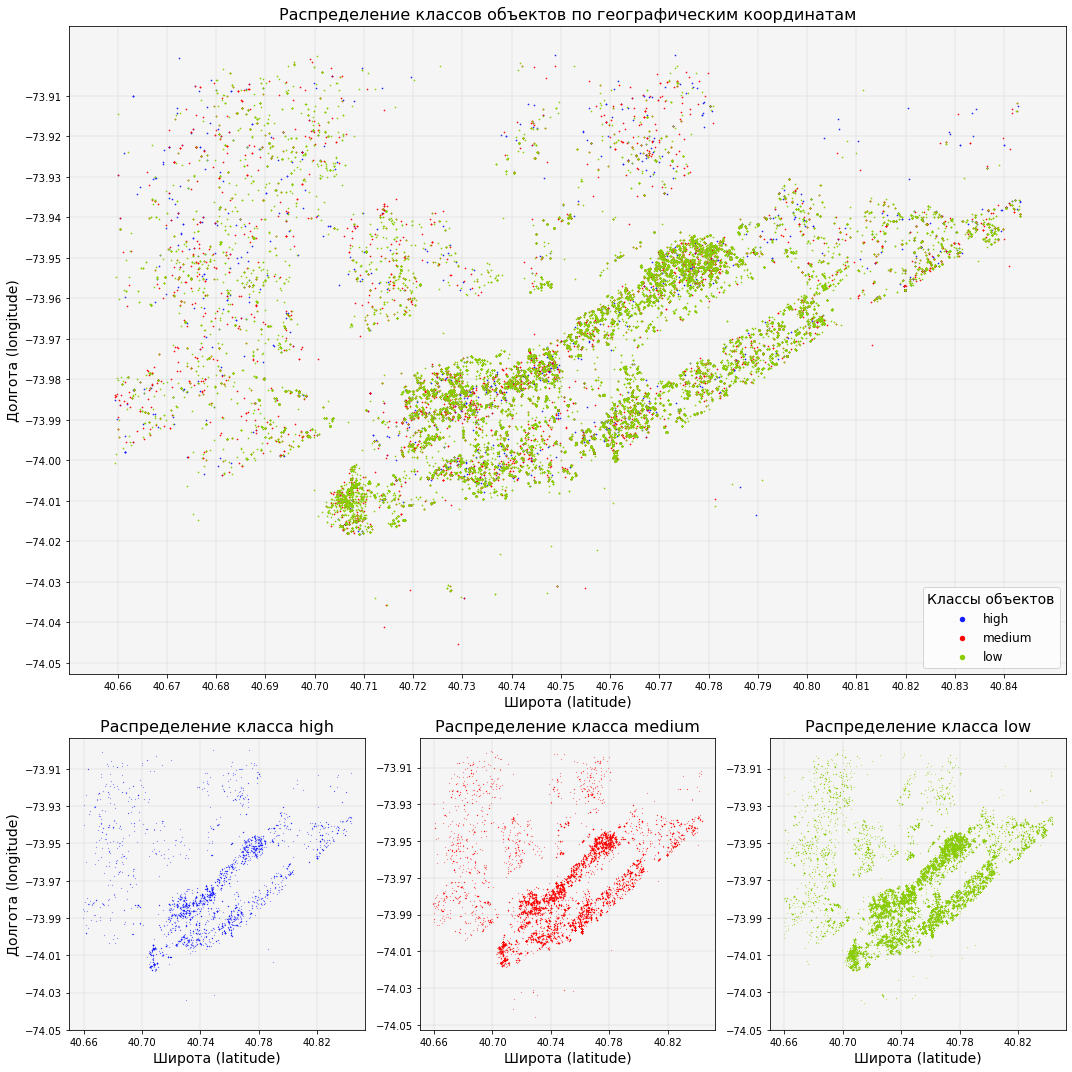

In [79]:
lower_latitude, upper_latitude = calculate_outlier_cutoff(train_df.latitude, 1.5)
lower_longitude, upper_longitude = calculate_outlier_cutoff(train_df.longitude, 1.5)

add_query = (train_df.longitude.between(lower_longitude, upper_longitude)) & \
            (train_df.latitude.between(lower_latitude, upper_latitude))

dict_lables = {'high': 0, 'medium': 1, 'low': 2}
dict_colors = {'high': '#141aff', 'medium': '#ff0000', 'low': '#89cd00'}
xticks = np.arange(lower_latitude, upper_latitude, 0.01).round(2)
yticks = np.arange(lower_longitude, upper_longitude, 0.01).round(2)

fig = plt.figure(tight_layout=True, figsize=(15,15))
gs = gridspec.GridSpec(3, 3)

ax = fig.add_subplot(gs[0:2, :])
for label, value in dict_lables.items():
    ax.scatter(train_df[(train_df.interest_level == value) & add_query].latitude, 
               train_df[(train_df.interest_level == value) & add_query].longitude, 
               label=label,
               c = dict_colors[label],
               s=0.4)
ax.set_xlabel("Широта (latitude)", fontsize=14)
ax.set_ylabel("Долгота (longitude)", fontsize=14)
ax.set_xticks(xticks)
ax.set_yticks(yticks) 
ax.set_facecolor('#f5f5f5')
ax.grid(linewidth=0.2)
ax.set_title('Распределение классов объектов по географическим координатам', fontsize=16)
ax.legend(title='Классы объектов', 
          markerscale=7,
          fontsize=12,
          title_fontsize=14,
          loc='lower right')

for label, value in dict_lables.items():
    ax = fig.add_subplot(gs[2, value])
    ax.scatter(train_df[(train_df.interest_level == value) & add_query].latitude, 
               train_df[(train_df.interest_level == value) & add_query].longitude, 
               label=label,
               c=dict_colors[label],
               s=0.03)
    ax.set_xlabel("Широта (latitude)", fontsize=14)
    if value == 0:
        ax.set_ylabel("Долгота (longitude)", fontsize=14)
    ax.set_yticks(yticks[::2])
    ax.set_facecolor('#f5f5f5')
    ax.set_xticks(xticks[::4])    
    ax.grid(linewidth=0.2, axis='both')
    ax.set_title(f'Распределение класса {label}', fontsize=16)
plt.show()

Какого-либо явного распределения классов объектов по географическим координатам не наблюдается.  
Посмотрим на распределение классов по географическим координатам, но c учетом стоимости.

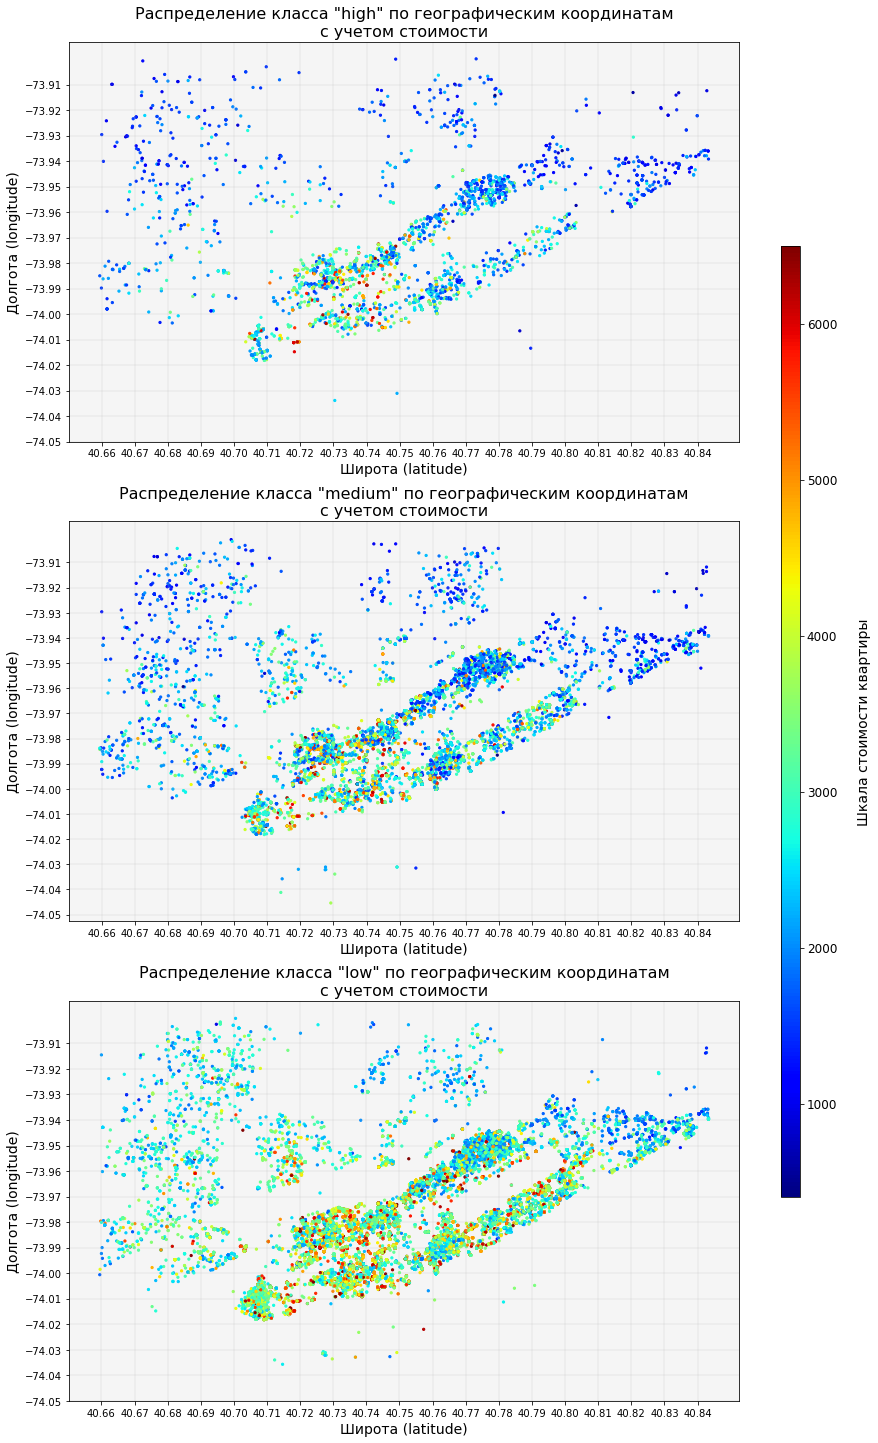

In [80]:
lower_latitude, upper_latitude = calculate_outlier_cutoff(train_df.latitude, 1.5)
lower_longitude, upper_longitude = calculate_outlier_cutoff(train_df.longitude, 1.5)
lower_price, upper_price = calculate_outlier_cutoff(train_df.price, 1.5)

add_query = (train_df.longitude.between(lower_longitude, upper_longitude)) & \
            (train_df.latitude.between(lower_latitude, upper_latitude)) & \
            (train_df.price.between(lower_price, upper_price))

cm = plt.cm.get_cmap('jet')
dict_lables = {'high': 0, 'medium': 1, 'low': 2}
dict_colors = {'high': '#141aff', 'medium': '#ff0000', 'low': '#89cd00'}
xticks = np.arange(lower_latitude, upper_latitude, 0.01).round(2)
yticks = np.arange(lower_longitude, upper_longitude, 0.01).round(2)
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 25))
           
for label, value in dict_lables.items():
    plot =ax[value].scatter(x=train_df[(train_df.interest_level == value) & add_query].latitude, 
                            y=train_df[(train_df.interest_level == value) & add_query].longitude,
                            c=train_df[(train_df.interest_level == value) & add_query].price,
                            s=5,
                            cmap=cm)
    ax[value].set_xlabel("Широта (latitude)", fontsize=14)
    ax[value].set_ylabel("Долгота (longitude)", fontsize=14)
    ax[value].set_xticks(xticks)
    ax[value].set_yticks(yticks) 
    ax[value].set_facecolor('#f5f5f5')
    ax[value].grid(linewidth=0.2)
    ax[value].set_title(f'Распределение класса "{label}" по географическим координатам\nc учетом стоимости', fontsize=16)     
    
cbar = fig.colorbar(plot, ax=ax[:], shrink=0.7, pad=0.05, aspect=50)
cbar.ax.tick_params(labelsize=12) 
cbar.set_label('Шкала стоимости квартиры', fontsize=14, labelpad=20)

plt.show()

Наблюдается только зависимость стоимости квартиры по географическим координатам. Чем дальше от центра, тем дешевле.

# Подготовка train_df и test_df к моделям обучения

In [81]:
all_df = pd.get_dummies(all_df, columns=['manager_id'])
train_df = all_df[all_df.interest_level.notna()]
test_df = all_df[all_df.interest_level.isna()].drop('interest_level', axis=1)

# Для колонок "latitude", "longitude", "price", "price_for_room" сделаем нормализацию
ss = StandardScaler()
column_to_scaler = ["latitude", "longitude", "price", "price_for_room"]
train_df[column_to_scaler] = ss.fit_transform(train_df[column_to_scaler])
test_df[column_to_scaler] = ss.fit_transform(test_df[column_to_scaler])

C:\Users\Maksim\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [82]:
X = train_df.drop(['interest_level'], axis=1)
y = train_df.interest_level
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [83]:
# Подготовим данные для CatBoostClassifier
pool_all = Pool(X, y)
pool_train = Pool(X_train, y_train)
pool_test = Pool(X_test, y_test)
pool_sub = Pool(test_df)

# Сравнение базовых моделей обучения ML

#### RandomForestClassifier - base

In [84]:
model = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)
print(f'Значение logloss \t= {log_loss(y_test, y_pred_prob):.4f}')
print(f'Значение accuracy \t= {accuracy_score(y_test, y_pred):.4f}')
print(f'Значение f_1_score \t= {f1_score(y_test, y_pred, average="macro"):.4f}')

Значение logloss 	= 0.6033
Значение accuracy 	= 0.7235
Значение f_1_score 	= 0.4777


#### CatBoostClassifier - Base

In [85]:
model = CatBoostClassifier(loss_function='MultiClass', random_state=42,)
model.fit(pool_train,       
          eval_set=pool_test, 
          verbose=False)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)
print(f'Значение logloss \t= {log_loss(y_test, y_pred_prob):.4f}')
print(f'Значение accuracy \t= {accuracy_score(y_test, y_pred):.4f}')
print(f'Значение f_1_score \t= {f1_score(y_test, y_pred, average="macro"):.4f}')

Значение logloss 	= 0.5583
Значение accuracy 	= 0.7512
Значение f_1_score 	= 0.5542


#### LogisticRegression - Base

In [86]:
model = LogisticRegression(max_iter=200, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)
print(f'Значение logloss \t= {log_loss(y_test, y_pred_prob):.4f}')
print(f'Значение accuracy \t= {accuracy_score(y_test, y_pred):.4f}')
print(f'Значение f_1_score \t= {f1_score(y_test, y_pred, average="macro"):.4f}')

Значение logloss 	= 0.7634
Значение accuracy 	= 0.6934
Значение f_1_score 	= 0.2931


#### XGBClassifier - Base

In [87]:
model = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)
print(f'Значение logloss \t= {log_loss(y_test, y_pred_prob):.4f}')
print(f'Значение accuracy \t= {accuracy_score(y_test, y_pred):.4f}')
print(f'Значение f_1_score \t= {f1_score(y_test, y_pred, average="macro"):.4f}')

Значение logloss 	= 0.5606
Значение accuracy 	= 0.7506
Значение f_1_score 	= 0.5609


#### LGBMClassifier - Base

In [88]:
model = lgb.LGBMClassifier(n_estimators=500, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)
print(f'Значение logloss \t= {log_loss(y_test, y_pred_prob):.4f}')
print(f'Значение accuracy \t= {accuracy_score(y_test, y_pred):.4f}')
print(f'Значение f_1_score \t= {f1_score(y_test, y_pred, average="macro"):.4f}')

Значение logloss 	= 0.5609
Значение accuracy 	= 0.7529
Значение f_1_score 	= 0.5787


**Результаты при базовых параметрах на моделях:**  
CatBoostClassifier, XGBClassifier, LGBMClassifier показали себя почти одинаково.

**будем использовать для дальнейшей настройки и прогноза CatBoostClassifier**

# Настройка  модели CatBoost

#### CatBoostClassifier - Search params

In [89]:
# Подберём параметры модели при помощи grid search
model_cb = CatBoostClassifier(loss_function = 'MultiClass',
                              random_state=42,
                              eval_metric='MultiClass',
                              custom_loss=['MultiClass', 'Accuracy'],
                              early_stopping_rounds=200,
                              verbose=False,
                              )

param_gs_cb = {'iterations': [5000],
               'learning_rate': [0.05, 0.1],
               'depth': [4, 5],
               'l2_leaf_reg': [3, 5],
               'min_data_in_leaf': [2],
               'auto_class_weights': ['None', 'Balanced'],
               'bagging_temperature': [0.3]}

grid_search_cb = model_cb.grid_search(param_gs_cb,
                                      pool_train,
                                      partition_random_seed = 42,
                                      plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.5489304689
bestIteration = 4994

0:	loss: 0.5489305	best: 0.5489305 (0)	total: 1m 8s	remaining: 17m 11s

bestTest = 0.5455479466
bestIteration = 4989

1:	loss: 0.5455479	best: 0.5455479 (1)	total: 2m 16s	remaining: 15m 55s

bestTest = 0.5519260172
bestIteration = 4994

2:	loss: 0.5519260	best: 0.5455479 (1)	total: 3m 28s	remaining: 15m 1s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.5491031855
bestIteration = 3784

3:	loss: 0.5491032	best: 0.5455479 (1)	total: 4m 32s	remaining: 13m 38s

bestTest = 0.5489304689
bestIteration = 4994

4:	loss: 0.5489305	best: 0.5455479 (1)	total: 5m 55s	remaining: 13m 1s

bestTest = 0.5455479466
bestIteration = 4989

5:	loss: 0.5455479	best: 0.5455479 (1)	total: 7m 11s	remaining: 11m 58s

bestTest = 0.5519260172
bestIteration = 4994

6:	loss: 0.5519260	best: 0.5455479 (1)	total: 8m 24s	remaining: 10m 49s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.5491031855
bestIteration = 3784

7:	loss: 0.54

In [90]:
model_cb.get_params()

{'loss_function': 'MultiClass',
 'verbose': False,
 'custom_loss': ['MultiClass', 'Accuracy'],
 'eval_metric': 'MultiClass',
 'random_state': 42,
 'early_stopping_rounds': 200,
 'min_data_in_leaf': 2,
 'depth': 5,
 'l2_leaf_reg': 3,
 'iterations': 5000,
 'bagging_temperature': 0.3,
 'learning_rate': 0.1,
 'auto_class_weights': 'None'}

In [91]:
# Обучим модель с лучшими параметрами и увеличим количество итераций
best_params_cb = model_cb.get_params()
best_params_cb['iterations'] = int(model_cb.tree_count_ * 2)

model_cb = CatBoostClassifier(**best_params_cb)
model_cb.fit(pool_train,       
             eval_set=pool_test, 
             verbose=2000,
             plot=True)

y_pred = model_cb.predict(X_test)
y_pred_prob = model_cb.predict_proba(X_test)
print(f'best iterations = {model_cb.tree_count_}')
print(classification_report(y_test, y_pred, target_names=list(dict_lables.keys()), digits=4))
print(f'Матрица ошибок: \n{confusion_matrix(y_test, y_pred)}')
print(f'Значение logloss = {log_loss(y_test, y_pred_prob):.4f}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.0270935	test: 1.0271774	best: 1.0271774 (0)	total: 29.3ms	remaining: 4m 52s
2000:	learn: 0.4814009	test: 0.5522337	best: 0.5521613 (1977)	total: 41.1s	remaining: 2m 44s
4000:	learn: 0.4361502	test: 0.5466785	best: 0.5466400 (3971)	total: 1m 26s	remaining: 2m 10s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.5459288536
bestIteration = 4395

Shrink model to first 4396 iterations.
best iterations = 4396
              precision    recall  f1-score   support

        high     0.6014    0.3359    0.4311       768
      medium     0.5147    0.3749    0.4338      2246
         low     0.8153    0.9281    0.8680      6857

    accuracy                         0.7562      9871
   macro avg     0.6438    0.5463    0.5776      9871
weighted avg     0.7302    0.7562    0.7352      9871

Матрица ошибок: 
[[ 258  345  165]
 [ 127  842 1277]
 [  44  449 6364]]
Значение logloss = 0.5459


In [92]:
best_params_cb = model_cb.get_params()
del best_params_cb['early_stopping_rounds']
del best_params_cb['eval_metric']
best_params_cb['iterations'] = int(model_cb.tree_count_ * 1.1)
best_params_cb['verbose'] = False
best_params_cb

{'iterations': 4835,
 'learning_rate': 0.1,
 'depth': 5,
 'l2_leaf_reg': 3,
 'loss_function': 'MultiClass',
 'verbose': False,
 'auto_class_weights': 'None',
 'custom_loss': ['MultiClass', 'Accuracy'],
 'bagging_temperature': 0.3,
 'random_state': 42,
 'min_data_in_leaf': 2}

In [93]:
# Посмотрим качество модели на кросс-валидации на всем train датасете
cv_data_best_params_cb = cv(params = best_params_cb,
                            pool = pool_all,
                            fold_count=5,
                            shuffle=True,
                            partition_random_seed = 42)

Training on fold [0/5]

bestTest = 0.5437980878
bestIteration = 4834

Training on fold [1/5]

bestTest = 0.5525260331
bestIteration = 4759

Training on fold [2/5]

bestTest = 0.55079789
bestIteration = 4833

Training on fold [3/5]

bestTest = 0.5380457837
bestIteration = 4824

Training on fold [4/5]

bestTest = 0.5453515611
bestIteration = 4798



#### CatBoostClassifier - best params

In [94]:
# Окончательное обучение модели на всем train датасете
model_cb = CatBoostClassifier(**best_params_cb)
model_cb.fit(pool_all)

### Запись результатов прогноза для sample_submission в файл

In [100]:
# Получение прогноза для sample_submission
sub_pred_prob = model_cb.predict_proba(pool_sub)

# Запись результатов прогноза для sample_submission в файл
sample_submission = pd.read_csv('sample_submission.csv')
submission_pred = sample_submission.copy()
submission_pred[['high', 'medium', 'low']] = sub_pred_prob
submission_pred.to_csv('submission_pred_v5.csv', index=False)